# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [147]:
# Load pickled data
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

np.random.seed(2606)

training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


Using the bounding box information, we create 3 datasets (for training, validation and testing) centered around the traffic signs:

In [148]:
'''
def build_raw_datasets(train, valid, test):

    X_train, y_train = np.array(train['features']), np.array(train['labels'])
    X_valid, y_valid = np.array(valid['features']), np.array(valid['labels'])
    X_test, y_test = np.array(test['features']), np.array(test['labels'])
    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = build_datasets(train, valid, test)
'''

"\ndef build_raw_datasets(train, valid, test):\n\n    X_train, y_train = np.array(train['features']), np.array(train['labels'])\n    X_valid, y_valid = np.array(valid['features']), np.array(valid['labels'])\n    X_test, y_test = np.array(test['features']), np.array(test['labels'])\n    return X_train, y_train, X_valid, y_valid, X_test, y_test\n\nX_train, y_train, X_valid, y_valid, X_test, y_test = build_datasets(train, valid, test)\n"

In [149]:
def crop_and_resize(x, original_size, box_coord):
    '''
    Takes a 32x32 image and crops it around the sign using the original
    image size and bounding box coordinates provided as args.
    
    x: Single image, size 32x32xChannels
    original_size: Tuple, size of the original image, before resizing to 
    32x32 (x1, y1, x2, y2)
    box_coord: Tuple, coordinates of the bounding box around the sign in 
    original image's coordinates (width, height)
    '''

    w = original_size[0]
    h = original_size[1]

    # Some test images have wrong original shapes
    if w < h // 2:
        w = h
    elif h < w //2:
        h = w
        
    x1 = np.round(box_coord[0] * 32 / w).astype('int')
    y1 = np.round(box_coord[1] * 32 / w).astype('int')
    x2 = np.round(box_coord[2] * 32 / w).astype('int')
    y2 = np.round(box_coord[3] * 32 / w).astype('int')
    x = x[x1:x2, y1:y2]
    
    return cv2.resize(x, dsize = (32, 32), 
                      interpolation = cv2.INTER_CUBIC).astype('uint8')


def build_dataset(dataset):
    '''
    Convenience function to build or rebuild a dataset from its orignal pickle,
    while croping around traffic signs and resizing to 32x32.
    
    dataset: Pickled dataset
    
    Returns a np.array containing all images in the dataset, croped and resized 
    around traffic signs.
    '''
    
    images = dataset['features']
    channels = images[0].shape[-1]
    x = np.zeros((len(dataset['features']), 32, 32, channels), dtype = 'uint8')
        
    for i, img in enumerate(images):
        original_size = dataset['sizes'][i]
        box_coord = dataset['coords'][i]
        x[i] = crop_and_resize(img, original_size, box_coord)
    
    y = dataset['labels']
    
    return x, y

X_train, y_train = build_dataset(train)
X_valid, y_valid = build_dataset(valid)
X_test, y_test = build_dataset(test)

The original data looks like this:

Sample data BEFORE cropping and resizing


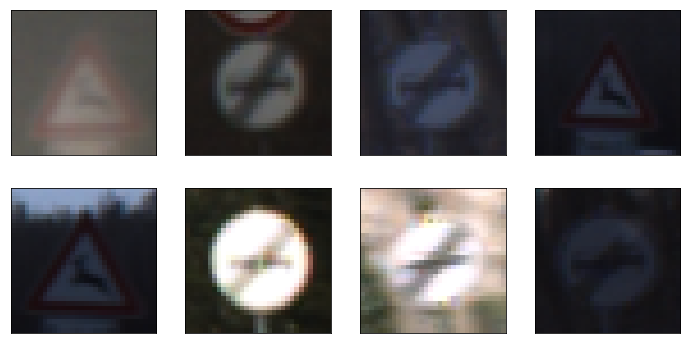

In [150]:
print("Sample data BEFORE cropping and resizing")

rand_images = np.random.randint(0, n_train, size = 8)
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6),
                        subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(train['features'][rand_images[i]])

After cropping and resizing to 32x32, it now looks like below. We got rid of a lot of unnecessary information, which hopefully should make the model more efficient. Note however that the bounding box coordinates are not 100% accurate (some images are off-centre).

Sample data AFTER cropping and resizing


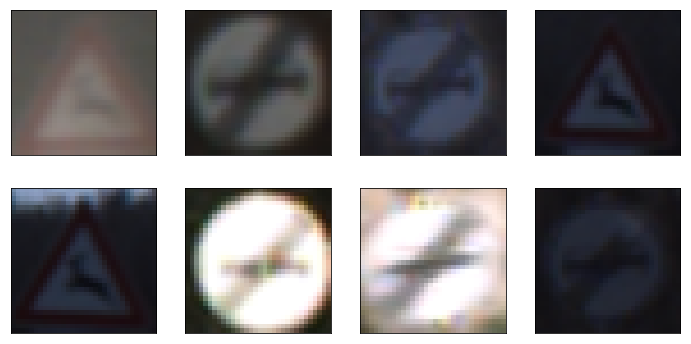

In [151]:
print("Sample data AFTER cropping and resizing")

fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6),
                        subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[rand_images[i]])

In [152]:
# For test purposes: Take a sample of the data
'''
sample_size = 500
sample_idx = np.round(np.random.sample(sample_size) * X_train.shape[0]).astype(np.int32)
X_train = X_train[sample_idx]
y_train = y_train[sample_idx]
print(X_train.shape, y_train.shape)
'''

'\nsample_size = 500\nsample_idx = np.round(np.random.sample(sample_size) * X_train.shape[0]).astype(np.int32)\nX_train = X_train[sample_idx]\ny_train = y_train[sample_idx]\nprint(X_train.shape, y_train.shape)\n'

### Basic Summary of the Train Data Set

In [153]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# Number of validation examples:
n_valid = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[np.random.randint(0, n_train)].shape[:2]  # Select a random image

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Exploratory visualization of the dataset

* **Sample images:**

In [154]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

We already looked at a few examples. Let's look at some more to get an idea of the possible challenges ahead.

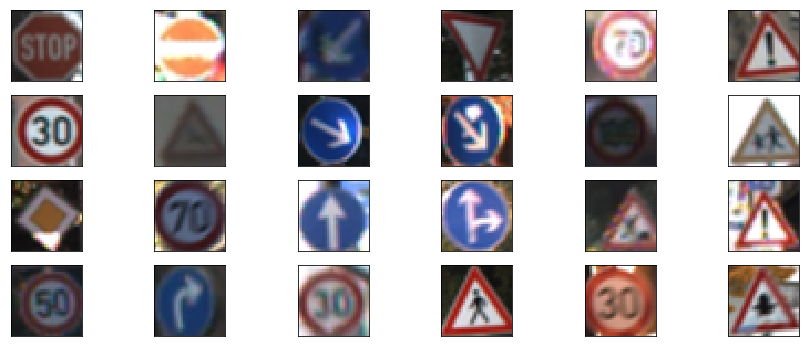

In [155]:
rand_images_2 = np.random.randint(0, n_train, size = 24)
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 6),
                        subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[rand_images_2[i]])

Some images are quite blurry, off-centre, tilted, dark etc. Some signs seem to have stickers on them. Some of the signs are even tough to read for humans!

* **Count of each sign:**

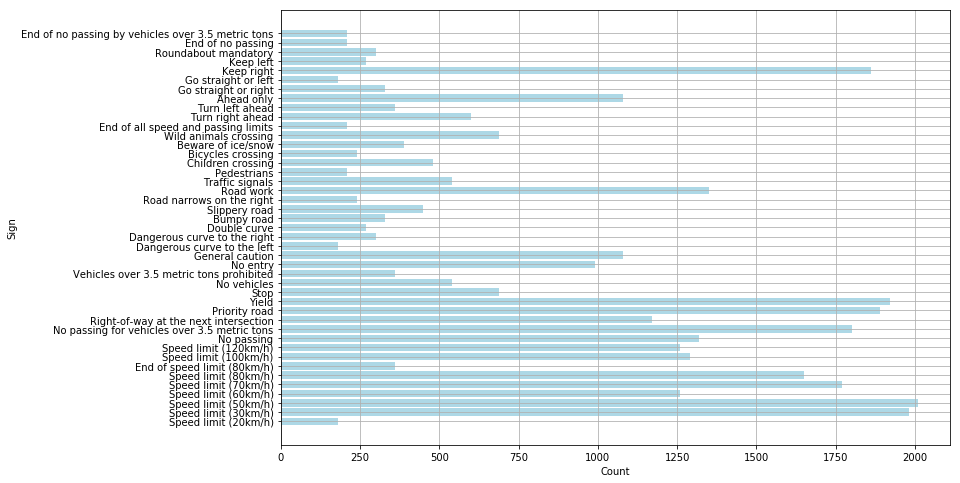

In [156]:
# First import the sign id mapping and make a data frame for the training set:
sign_labels = pd.DataFrame(y_train, columns = ['labels'])
sign_names = pd.read_csv('signnames.csv', index_col = 'ClassId')
signs_train = pd.DataFrame(X_train[:, 0, 0, 0], 
                           columns = ['num_example'])
signs_train = pd.concat([signs_train, sign_labels], axis = 1)
signs_train = signs_train.join(sign_names, on = 'labels')

signs_train_grp = signs_train.groupby(['labels', 'SignName'], 
                                      as_index = False).count()

plt.figure(figsize = (12, 8))    
plt.barh(signs_train_grp['labels'], signs_train_grp['num_example'], color = 'lightblue')
plt.xlabel('Count')
plt.ylabel('Sign')
plt.yticks(signs_train_grp['labels'], signs_train_grp['SignName'])
plt.grid(True)
plt.show()


The dataset is very unbalanced, which might lead to accuracy issues when predicting certain classes. As part of the pre-processing, we will need to re-balance classes.

## Step 2: Data Pre-processing and Augmentation

* **Conversion to Grayscale and histogram equalization**

From trial and error, I found that I got generally slightly better results with grayscale images than RGB or single channel Y (from YCrCb). We therefore convert the three datasets to grayscale and equalize histograms to improve contrast.

In [157]:
# Conversions to different colour maps

def convert_to_grey(x):
    '''
    Converts a collection of images (stored as a single np.ndarray, axis 0 denoting the
    index within the collection) to greyscale while equalizing histograms.
    Returns a collection of 1-channel images of same dimensions.
    
    x: a 3-channel array
    '''
    x_out = np.zeros((x.shape[0], x.shape[1], x.shape[2]))
    for i in range(x_out.shape[0]):
        x_out[i] = cv2.equalizeHist(cv2.cvtColor(x[i], cv2.COLOR_RGB2GRAY))
    
    return x_out[:, :, :, np.newaxis]

def convert_to_Y(x):
    '''
    Converts a collection of images (stored as a single np.ndarray, axis 0 denoting the
    index within the collection) to the Y channel (in YCrCb) while equalizing histograms.
    Returns a collection of 1-channel images of same dimensions.
    
    x: a 3-channel array
    '''
    x_out = np.zeros((x.shape[0], x.shape[1], x.shape[2]))
    for i in range(x_out.shape[0]):
        x_out[i, :, :] = cv2.equalizeHist(cv2.cvtColor(x[i], cv2.COLOR_RGB2YCrCb)[:, :, 0])
    
    return x_out[:, :, :, np.newaxis]


X_train = convert_to_grey(X_train)
X_valid = convert_to_grey(X_valid)
X_test = convert_to_grey(X_test)
#X_train = convert_to_Y(X_train)
#X_valid = convert_to_Y(X_valid)
#X_test = convert_to_Y(X_test)

The resulting images look like below:

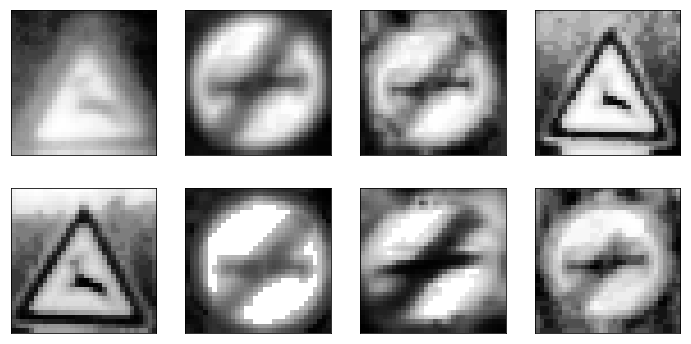

In [158]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6),
                        subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[rand_images[i],:,:,0], cmap = 'gray')  # Display an image

* **Re-balancing data:**

Here we generate copies of each image in order to approximately balance all classes in the dataset. There copies are randomly jittered and colour-adjusted.

In [159]:
import copy

VARIATIONS = 4  # Number of fake images to generate for each real one

def jitter_image(x):
    '''
    Takes an image and returns a jittered version of it by applying random
    scaling, translation and rotation.
    
    x: an image array
    
    '''
    s_y, s_x = x[:,:,0].shape  # Store original shape
    
    # Scale by a random factor between .9 and 1.1
    scaling_x = 0.2 * np.random.sample() + 0.9
    scaling_y = 0.2 * np.random.sample() + 0.9 
    img = cv2.resize(x, dsize = (0, 0), fx = scaling_x, fy = scaling_y)
    
    # Restore original array size by adding padding
    s_y_new, s_x_new = x[:,:,0].shape  # Get new shape after resizing
    y_padding = round(s_y - s_y_new)
    x_padding = round(s_x - s_x_new)
    x = cv2.copyMakeBorder(x, y_padding, y_padding, x_padding, x_padding, 
                             cv2.BORDER_WRAP)
     
    # Translate by a random number of pixels between -1 and +1
    trans_x = 2. * np.random.sample() - 1
    trans_y = 2. * np.random.sample() - 1
    M_trans = np.float32([[1, 0, trans_x], [0, 1, trans_y]])  # Define translation matrix
    x = cv2.warpAffine(x, M = M_trans, dsize = (32, 32),  # Apply translation
                       borderMode = cv2.BORDER_WRAP)
    
    # Rotate by a random angle between -5 and +5 degrees
    rot_deg = 10 * np.random.sample() - 5
    M_rot = cv2.getRotationMatrix2D((round(s_x / 2), round(s_y / 2)), rot_deg, 1) # Define rot. matrix
    x = cv2.warpAffine(x, M = M_rot, dsize = (s_x, s_y),  # Apply rotation
                       borderMode = cv2.BORDER_WRAP)  
       
    return x[:, :, np.newaxis]


def adjust_channels(x):
    '''
    Takes an image and applies a different adjustment to each channel 
    sampled from the interval [.95, 1.05]. Returns the modified image.
    
    x: an image array
    '''
    for chan in range(x.shape[2]):
        adj_coeff = 1. + np.random.randn() * 0.05
        lower = np.zeros_like(x[:,:, chan])
        upper = np.zeros_like(x[:,:, chan]) + 255
        x[:,:, chan] = np.maximum(lower, x[:,:, chan] * adj_coeff)
        x[:,:, chan] = np.minimum(x[:,:, chan], upper)
    return x


def balance_data(x, y):
    '''
    Creates copies of the different images so that the total count of all classes is roughtly the same.
    Only run once, during pre-processing phase.
    
    x: input array of images (each slice along 0 corresponds to an image)
    y: array of labels
    
    Returns 
    '''
    initial_len = len(y)  # Number of rows in the original dataset
    idx_list = [i for i in range(initial_len)]  # Initialize index list with indices of y examples
    count_per_label = np.bincount(y, minlength = 43)  # Count the number of examples for each label
    max_count = np.max(count_per_label) # Count of the largest class
                             
    for i in range(initial_len):  # Loop through the dataset to build a pointer array representing
        # the final X_out and y_out np.arrays       
        lbl_count = count_per_label[y[i]]
        copies_to_add = int(round((max_count - lbl_count) / lbl_count))
        idx_list.extend([i] * copies_to_add)
    
    x_out = np.zeros((len(idx_list), x.shape[1], x.shape[2], x.shape[3]), 
                     dtype = np.float32)                 # Reserve space for X_out
    y_out = np.zeros(len(idx_list), dtype = np.float32)  # Reserve space for y_out
    
    for i in range(len(idx_list)):  # Fill x_out and y_out with copies of x[i] and y[i] as 
        # required by idx_list
        if i < initial_len:  # If the image is part of the original data, keep it untouched
            x_out[i] = x[idx_list[i]]
        else:  # If it's generated to balance the data, jitter and clour-adjust it
            x_out[i] = adjust_channels(jitter_image(x[idx_list[i]]))
        y_out[i] = y[idx_list[i]]
    
    return x_out, y_out

X_train, y_train = balance_data(X_train, y_train)

Size of training dataset: 87657


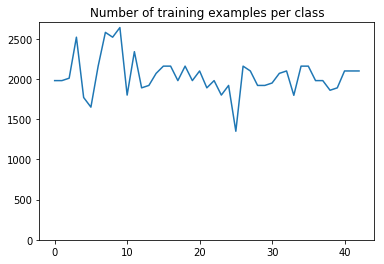

In [160]:
plt.plot([np.bincount(y_train.astype(np.int32), minlength = 43)[i] for i in range(43)])
plt.title("Number of training examples per class")
plt.ylim((0, None))

print("Size of training dataset:", len(X_train))

We can see that the dataset is now much more balanced than previously.

* **Data augmentation:**

We then create 4 variations of each image, with random jittering and colour-adjustments. Note that at this point, the majority of the dataset already consists of random variations of the original images (due to the class balancing performed previously), so copies of these will actually be jittered twice. The mean movement is still zero, but variance will be doubled.

In [161]:
def create_fakes(x, y):
    '''
    Takes a single image as input and produces 5 variations with random
    jittering and channel adjustments.
    
    x: Single image (a 3-dimensional np.ndarray))
            
    Returns: An 4d-array of stacked images such that x_out.shape[0] == variations
    '''
    x_out = np.array([adjust_channels(jitter_image(x)) for img in range(VARIATIONS)])
    y_out = np.array([y for img in range(VARIATIONS)])  # Don't change y but replicate each value
    return x_out, y_out

# Apply this process to all images in the training set:
X_train_fake = np.concatenate([fake_x for fake_x in map(lambda x, y: create_fakes(x, y)[0], 
                                                        X_train, y_train)], 0)
y_train_fake = np.concatenate([fake_x for fake_x in map(lambda x, y: create_fakes(x, y)[1], 
                                                        X_train, y_train)], 0)

# Concatenate to existing training set
X_train = np.concatenate((X_train, X_train_fake), 0)
y_train = np.concatenate((y_train, y_train_fake), 0)

* **Normalization:**

Finally, we normalize the data to values between -1 and +1.

In [162]:
# Normalisation:

def normalize_per_image(x):
    channels = x.shape[-1]
    x_out = np.zeros_like(x, dtype = np.float32)
    for index, img in enumerate(x):
        x_out[index] = cv2.normalize(img, x_out[index], alpha = -1, beta = 1, 
                      norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    return x_out

def center_global(x):
    x_out = np.zeros_like(x, dtype = np.float64)
    mean_img = np.mean(x, axis = 0, dtype = np.float64, keepdims = True)
    x_out = x - mean_img
    
    return x_out

def center_per_channel(x):
    x_out = np.zeros_like(x, dtype = np.float64)
    
    for c in range(x.shape[-1]):  # Apply zero centering by channel
        x_out[:,:,:,c] = x[:,:,:,c] - np.mean(x[:,:,:,c], dtype = np.float64, keepdims = True)
    
    return x_out

X_train = normalize_per_image(X_train)
X_valid = normalize_per_image(X_valid)
X_test = normalize_per_image(X_test)

After all these steps, the dataset contains a lot more examples than initially.

Size of training dataset: 438285


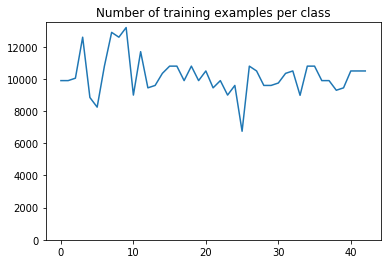

In [163]:
plt.plot([np.bincount(y_train.astype(np.int32), minlength = 43)[i] for i in range(43)])
plt.title("Number of training examples per class")
plt.ylim((0, None))

print("Size of training dataset:", len(X_train))

At this point, we save our dataset.

In [164]:
with open('./data/x_train_with_fakes.p', mode = 'wb') as f:
    pickle.dump(X_train, f)
with open('./data/y_train_with_fakes.p', mode = 'wb') as f:
    pickle.dump(y_train, f)
with open('./data/x_valid.p', mode= 'wb') as f:
    pickle.dump(X_valid, f)
with open('./data/y_valid.p', mode= 'wb') as f:
    pickle.dump(y_valid, f)
with open('./data/x_test.p', mode= 'wb') as f:
    pickle.dump(X_test, f)
with open('./data/y_test.p', mode= 'wb') as f:
    pickle.dump(y_test, f)

----

## Step 3: Design and Test a Model Architecture


In [165]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle
import cv2
import tensorflow as tf
from copy import copy


In [166]:
with open('./data/x_train_with_fakes.p', mode = 'rb') as f:
    X_train = pickle.load(f)
with open('./data/y_train_with_fakes.p', mode = 'rb') as f:
    y_train = pickle.load(f)
with open('./data/x_valid.p', mode= 'rb') as f:
    X_valid = pickle.load(f)
with open('./data/y_valid.p', mode= 'rb') as f:
    y_valid = pickle.load(f)
with open('./data/x_test.p', mode= 'rb') as f:
    X_test = pickle.load(f)
with open('./data/y_test.p', mode= 'rb') as f:
    y_test = pickle.load(f)

### Model Architecture

The architecture I am using is adapted from LeNet-5 with the following changes:

- Each of the two 5x5 convolutions are now deeper and are followed by a ReLU activation
- A 1x1 convolution is inserted after each 5x5 convo's ReLU unit
- The first two fully-connected layers are each followed by a dropout unit

In [167]:
from tensorflow.contrib.layers import flatten

# ConvNet filter and stride sizes:
cv1_fsize, cv1_stride = 5, 1
pl1_ksize, pl1_stride = 2, 2
cv2_fsize, cv2_stride = 5, 1
pl2_ksize, pl2_stride = 2, 2
    

def LuNet(x, keep_prob, n_channels = 1):    
    '''
    Defines the ConvNet's architecture.
    '''
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # Define weight variables:
    weights = {
        'cv1_w': tf.Variable(tf.truncated_normal([cv1_fsize, cv1_fsize, n_channels, 12], mu, sigma)), 
        'cv1a_w': tf.Variable(tf.truncated_normal([1, 1, 12, 6], mu, sigma)),
        'cv2_w': tf.Variable(tf.truncated_normal([cv2_fsize, cv2_fsize, 6, 24], mu, sigma)), 
        'cv2a_w': tf.Variable(tf.truncated_normal([1, 1, 24, 16], mu, sigma)),
        'fc3_w': tf.Variable(tf.truncated_normal([400, 120], mu, sigma)),
        'fc4_w': tf.Variable(tf.truncated_normal([120, 84], mu, sigma)),
        'fc5_w': tf.Variable(tf.truncated_normal([84, 43], mu, sigma))
    }
    biases = {
        'cv1_b': tf.Variable(tf.truncated_normal([12])),
        'cv1a_b': tf.Variable(tf.truncated_normal([6])),
        'cv2_b': tf.Variable(tf.truncated_normal([24])),
        'cv2a_b': tf.Variable(tf.truncated_normal([16])),
        'fc3_b': tf.Variable(tf.truncated_normal([120], mu, sigma)),
        'fc4_b': tf.Variable(tf.truncated_normal([84], mu, sigma)),
        'fc5_b': tf.Variable(tf.truncated_normal([43], mu, sigma))
    }
        
   
    # Layer 1: Convolutional. Input = 32x32xChannels. Output = 28x28x12.
    cv1 = tf.nn.conv2d(x, weights['cv1_w'], strides = [1, cv1_stride, cv1_stride, 1], 
                       padding = 'VALID')
    cv1 = tf.nn.bias_add(cv1, biases['cv1_b'])
    cv1 = tf.nn.relu(cv1)
    
    # Layer 1a: 1x1 Convolutional. Input = 28x28x12. Output = 28x28x6.
    cv1a = tf.nn.conv2d(cv1, weights['cv1a_w'], strides = [1, 1, 1, 1], 
                        padding = 'SAME')
    cv1a = tf.nn.bias_add(cv1a, biases['cv1a_b'])
    ac1 = tf.nn.relu(cv1a)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pl1 = tf.nn.max_pool(ac1, ksize = [1, pl1_ksize, pl1_ksize, 1], 
                         strides = [1, pl1_stride, pl1_stride, 1], padding = 'VALID')
        
    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x24.
    cv2 = tf.nn.conv2d(pl1, weights['cv2_w'], strides = [1, cv2_stride, cv2_stride, 1],
                       padding = 'VALID')
    cv2 = tf.nn.bias_add(cv2, biases['cv2_b'])
    cv2 = tf.nn.relu(cv2)
    
    # Layer 2a: 1x1 Convolutional. Input = 10x10x24. Output = 10x10x16.
    cv2a = tf.nn.conv2d(cv2, weights['cv2a_w'], strides = [1, 1, 1, 1],
                       padding = 'SAME')                          
    cv2a = tf.nn.bias_add(cv2a, biases['cv2a_b'])
    ac2 = tf.nn.relu(cv2a)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pl2 = tf.nn.max_pool(ac2, ksize = [1, pl2_ksize, pl2_ksize, 1],
                         strides= [1, pl2_stride, pl2_stride, 1], padding = 'VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    flat = tf.contrib.layers.flatten(pl2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc3 = tf.add(tf.matmul(flat, weights['fc3_w']), biases['fc3_b'])
    
    # Activation.
    ac3 = tf.nn.relu(fc3)
    
    # Dropout:
    do3 = tf.nn.dropout(ac3, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84
    fc4 = tf.add(tf.matmul(do3, weights['fc4_w']), biases['fc4_b'])
    
    # Activation.
    ac4 = tf.nn.relu(fc4)
    
    # Dropout:
    do4 = tf.nn.dropout(ac4, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(do4, weights['fc5_w']), biases['fc5_b'])
    
    return logits

### Train, Validate and Test the Model

We can now train this architecture.

In [ ]:
# Number of channels:
chan = X_train.shape[-1]

# Meta-parameters:
EPOCHS = 300
BATCH_SIZE = 64
TRAIN_TARGET = 0.97
VALID_TARGET = 0.97
initial_rate = 0.001

tf.set_random_seed(2302)
x = tf.placeholder(tf.float32, (None, 32, 32, chan))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)
rate = tf.placeholder(tf.float32)

logits = LuNet(x, keep_prob, chan)
softmax_prob = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
preds_operation = tf.argmax(tf.nn.softmax(logits), 1)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, l_rate):
    preds = []
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, batch_preds = sess.run([accuracy_operation, preds_operation], 
                            feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, rate: l_rate})
        total_accuracy += (accuracy * len(batch_x))
        preds.append(batch_preds)
    return total_accuracy / num_examples, preds

In [ ]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    train_accuracies = []
    valid_accuracies = []
    
    print("Training...")
    print()
    t = 0
    l_rate = initial_rate
    
    while True:
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.4,
                                                   rate: l_rate})
        
        training_accuracy, _ = evaluate(X_train, y_train, l_rate)    
        validation_accuracy, predictions = evaluate(X_valid, y_valid, l_rate)
        
        train_accuracies.append(training_accuracy)
        valid_accuracies.append(validation_accuracy)
        
        print("EPOCH {}, learning rate = {:.4f} ...".format(t + 1, l_rate))
        print("Training Accuracy = {:.4f}".format(training_accuracy))
        print("Validation Accuracy = {:.4f}".format(validation_accuracy))
        print()
        
        t += 1
            
        if validation_accuracy >= VALID_TARGET or t + 1 >= EPOCHS or \
            training_accuracy > TRAIN_TARGET:
            break
        
    saver.save(sess, './lunet')
    print("Model saved")

Training...


We plot the training and validation accuracy curves:

In [ ]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.plot(valid_accuracies, c = 'b')
ax.plot(train_accuracies, c = 'g')
plt.ylim(0.5, 1.)

Let's look at some misclassifications:

In [ ]:
# Turn the list into a flat array:
predictions_flat = [item for batch in predictions for item in batch]
predictions_flat = np.array(predictions_flat, order = 'C')

wrong_idx = [i for i in range(len(predictions_flat)) if predictions_flat[i] != y_valid[i]]
print("Number of misclassifications: %d" % len(wrong_idx))

# Plot the learning mistakes:
f, axis = plt.subplots(nrows = min([len(wrong_idx) // 8 + 1, 8]), ncols = 8, figsize = (16, 16),
                       subplot_kw = {'xticks': [], 'yticks': []})

for i in range(min([len(wrong_idx), 64])):
    img_idx = wrong_idx[i]
    axis[i//8, i%8].set_title("%d, pred %d" % (y_valid[img_idx], predictions_flat[img_idx]))
    axis[i//8, i%8].imshow(X_valid[img_idx][:, :, 0], cmap = 'gray')

Finally, let's assess the prediction accuracy on the unseen test set:

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy, _ = evaluate(X_test, y_test, l_rate)
print('Test accuracy = {:.3f}'.format(test_accuracy))

---

## Step 4: Test Model on New Images

We downloaded 6 images from the Internet and test the model against these.

### Load and Output the Images

In [ ]:
# Load the test examples:
filenames = ['double_curve.png', 'limit_50.png', 'roadworks.png', 'bumps.png', 
             'stop.png', 'wild_animals.png']

test_ex = np.zeros((len(filenames), 32, 32, 3))
test_ex_labels = [21, 2, 25, 22, 14, 31]  # Actual labels for test examples
for i, fn in enumerate(filenames):
    test_ex[i] = plt.imread('./data/more_examples/' + fn)

In [ ]:
# Plot the images
fig, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (12, 4),
                        subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(test_ex[i])  # Display an image

### Predict the Sign Type for Each Image

In [ ]:
# Convert arrays to integer (for cv2 functions):
test_ex = np.round(test_ex * 255).astype('uint8')

# Apply pre-processing to the test examples:
test_ex = convert_to_grey(test_ex)  # Histogram normalization and conversion to grayscale
test_ex = normalize_per_image(test_ex)  # Normalization of each image to [-1., +1.]

In [ ]:
# Plot the images
fig, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (12, 4),
                        subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(test_ex[i,:,:,0], cmap = 'gray')  # Display an image

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_ex_accuracy, predictions = evaluate(test_ex, test_ex_labels, l_rate)
print('Accuracy on test examples= {:.3f}'.format(test_ex_accuracy))

preds_vs_labels = pd.DataFrame({'labels': test_ex_labels, 
                                'predictions': predictions[0].tolist()})
preds_vs_labels = preds_vs_labels.join(sign_names, on = 'labels')
preds_vs_labels.rename(columns = {'SignName': 'label_names'}, inplace = True)
preds_vs_labels = preds_vs_labels.join(sign_names, on = 'predictions')
preds_vs_labels.rename(columns = {'SignName': 'pred_names'}, inplace = True)
preds_vs_labels = preds_vs_labels[['labels', 'label_names', 'predictions', 'pred_names']]
print(preds_vs_labels)

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
print(test_ex_accuracy)

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax_p = sess.run(tf.nn.top_k(softmax_prob, k = 5), feed_dict = {x: test_ex, keep_prob: 1.})

print(softmax_p)

In [ ]:
import re
prob_list = []

for i in range(6):
    names_str = [re.sub(r"(SignName)|(Name:\s\d+,\sdtype:\sobject)|\n", "",
                        str(sign_names.loc[softmax_p.indices[i][j]]))
                    for j in range(len(softmax_p.indices[i]))]
    prob_list.append(pd.DataFrame({'labels': softmax_p.indices[i], 
                                  'probs': softmax_p.values[i],
                                  'names': names_str
                                  }))
    
print(prob_list)

# Plot the images
fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize = (12, 20))

for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax.barh(prob_list[i // 2].loc[:, 'labels'], prob_list[i // 2].loc[:, 'probs'], 
                color = 'lightblue')
        ax.set_xlim((0., 1.))
        ax.set_xlabel('Prob')
        ax.set_ylim((0, 43))
        ax.set_ylabel('Sign')
        ax.set_yticks(prob_list[i // 2].loc[:, 'labels'])
        ax.set_yticklabels(prob_list[i // 2].loc[:, 'names'])
        
        
    if i % 2 == 1:
        ax.imshow(test_ex[i // 2,:,:,0], cmap = 'gray')  # Display an image
        ax.set_xticks([])
        ax.set_yticks([])

        


> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 